In [1]:
using DifferentialEquations
using PyPlot
using Flux
using Statistics

In [2]:
tmax = 1000.0
names = ["lungs", "heart", "kidney", "liver", "spleen",  "Gut tissue", "Other Tissue"]  

7-element Vector{String}:
 "lungs"
 "heart"
 "kidney"
 "liver"
 "spleen"
 "Gut tissue"
 "Other Tissue"

In [3]:
#Model Parameters
A_i=[.0019956689, .0009621096822, .0033612343, .0045212562, .0004750356, .003333333, .003333333].*1000 #mouse dm^2 
l_NC_b  = (100*10^(-9)) # m
Q_i=[74.83758415, 138.673326, 763.9168803, 284.6716878, 224.48828292, 333, 1000]./(60*10^6) #L/sec MOUSE
V_i_BL=[43.65525742 ,20.04395171 ,1018.55584 ,127.7673516 ,2.226207538 ,90 ,700]./10^6
V_i_T=[33.26114851 ,16.03516137 ,56.02057122 ,75.3542703 ,7.91726 ,20 ,1000]./10^6 #L MOUSE

V_vein = 466.9/10^6 # mouse L
Q_hep = sum(Q_i[4:6]) #flow out of the liver
V_hep = sum(V_i_BL[4:6]) #total volume of blood passed thru liver
Q_vein = Q_i[3]+Q_hep+Q_i[7] #L/sec Mouse

4.3434614183666664e-5

In [4]:
#Rate Constants
#Kon and Koff
slope1 = (22-4)/(500-50)
slope2 = 3.9
slope = slope1*slope2
a = [4, 15, 50, 79, 100]
r = a/2
K_EC0=[1.23e42, 10.6565662, 41793.3924, 2.28e12, 7.74e21, 3.33e15, 3.33e15]
K_EC0 = log.(K_EC0)
K_EC = zeros(5, 7)
for i =1:7
    K_EC[1:4,i] = slope*r[1:4] .- slope*r[end] .+ K_EC0[i]
    K_EC[end, i] = K_EC0[i]
end
K_EC[:, 2] .= K_EC0[2]

Kb = 1.36e-23
T = 310
mu = 0.0037
l = 1e-7
r = r*1e-9
D=Kb*T./(6*pi*mu*r)
k_i_on = D./l^2
K_i_on = zeros(5, 7)
K_i_off = zeros(5, 7)
for i = 1:5
  K_i_on[i, :] .= k_i_on[i]
  K_i_off[i, :] = K_i_on[i]./K_EC[i, :]  
end

K_i_on = K_i_on[1, :]
K_i_off = K_i_off[1, :]
K_deg_vein = 1/6000

#Other Parameters
p = [2.0e-6 1.0 1.0; 2e-6 0.1 0.02; 0.0004 0.0033 0.02; 5.0e-6 0.005 0.02; 2e-5 0.08 0.014; 3.3e-5 0.01 0.02; 3.3e-5 0.01 0.02]
#Rate of Degredation of NP in each organ
K_i_deg = p[:, 1]
#Rate of uptake of NP in each organ
K_i_up = p[:, 2]
#Rate of non specific uptake of NP in each organ
K_NS= p[:, 3]

7-element Vector{Float64}:
 1.0
 0.02
 0.02
 0.02
 0.014
 0.02
 0.02

In [5]:
#ODE matrix for linear system (dy/dt = Ay)
A = [-(Q_i[1]/V_i_BL[1]+K_i_on[1]+K_NS[1]+K_i_deg[1]) Q_i[1]/V_i_BL[2] 0 0 0 0 0 K_i_off[1] 0 0 0 0 0 0;
Q_i[1]/V_i_BL[1] -((Q_i[1]+Q_vein)/V_i_BL[2] + K_i_on[2]+K_NS[2]+K_i_deg[2]) 0 0 0 0 0 0 K_i_off[2] 0 0 0 0 0;
0 0 -(Q_i[3]/V_i_BL[3] + K_i_on[3]+K_NS[3]+K_i_deg[3]) 0 0 0 0 0 0 K_i_off[3] 0 0 0 0;
0 0 0 -(Q_hep/V_i_BL[4]+K_i_on[4]+K_NS[4]+K_i_deg[4]) Q_i[5]/V_i_BL[5] Q_i[6]/V_i_BL[6] 0 0 0 0 K_i_off[4] 0 0 0;
0 0 0 0 -(Q_i[5]/V_i_BL[5]+K_i_on[5]+K_NS[5]+K_i_deg[5]) 0 0 0 0 0 0 K_i_off[5] 0 0;
0 0 0 0 0 -(Q_i[6]/V_i_BL[6] + K_i_on[6] + K_i_deg[6] + K_NS[6]) 0 0 0 0 0 0 K_i_off[6] 0;
0 0 0 0 0 0 -(Q_i[7]/V_i_BL[7] + K_i_on[7] + K_NS[7] + K_i_deg[7]) 0 0 0 0 0 0 K_i_off[7];
K_i_on[1] 0 0 0 0 0 0 -(K_i_up[1] + K_i_off[1] + K_i_deg[1]) 0 0 0 0 0 0;
0 K_i_on[2] 0 0 0 0 0 0 -(K_i_up[2] + K_i_off[2] + K_i_deg[2]) 0 0 0 0 0;
0 0 K_i_on[3] 0 0 0 0 0 0 -(K_i_up[3] + K_i_off[3] + K_i_deg[3]) 0 0 0 0;
0 0 0 K_i_on[4] 0 0 0 0 0 0 -(K_i_up[4] + K_i_off[4] + K_i_deg[4]) 0 0 0;
0 0 0 0 K_i_on[5] 0 0 0 0 0 0 -(K_i_up[5] + K_i_off[5] + K_i_deg[5]) 0 0;
0 0 0 0 0 K_i_on[6] 0 0 0 0 0 0 -(K_i_up[6] + K_i_off[6] + K_i_deg[6]) 0;
0 0 0 0 0 0 K_i_on[7] 0 0 0 0 0 0 -(K_i_up[7] + K_i_off[7] + K_i_deg[7])]

14×14 Matrix{Float64}:
 -3023.54           0.0622279      0.0   …    0.0        0.0       0.0
     0.0285714  -3024.76           0.0        0.0        0.0       0.0
     0.0            0.0        -3022.54       0.0        0.0       0.0
     0.0            0.0            0.0        0.0        0.0       0.0
     0.0            0.0            0.0       70.4339     0.0       0.0
     0.0            0.0            0.0   …    0.0      106.977     0.0
     0.0            0.0            0.0        0.0        0.0     106.977
  3022.51           0.0            0.0        0.0        0.0       0.0
     0.0         3022.51           0.0        0.0        0.0       0.0
     0.0            0.0         3022.51       0.0        0.0       0.0
     0.0            0.0            0.0   …    0.0        0.0       0.0
     0.0            0.0            0.0      -70.514      0.0       0.0
     0.0            0.0            0.0        0.0     -106.987     0.0
     0.0            0.0            0.0        0.0   

In [6]:
#ODE function with quasi-steady-state component
function func_qss!(dydt, y, p, t)
  b_vec = [0; -Q_vein*y[1]/V_vein; -Q_i[3]*y[2]/V_vein;-Q_i[4]*y[2]/V_vein;
          -Q_i[5]*y[2]/V_vein;-Q_i[6]*y[2]/V_vein;
          -Q_i[7]*y[2]/V_vein;
           0;0;0;0;0;0;0]

  #Steady-State component
  y_ss = A\b_vec

  #Vein
  dydt[1] = (Q_i[3]*y_ss[3]/V_i_BL[3] + Q_hep*y_ss[4]/V_i_BL[4] + Q_i[7]*y_ss[7]/V_i_BL[7] - Q_vein*y[1]/V_vein - y[1]*K_deg_vein) 
  # Artery 
  dydt[2] = (Q_vein*y_ss[2]/V_i_BL[2]-(Q_i[3]*y[2] + Q_i[4]*y[2]+ Q_i[5]*y[2] + Q_i[6]*y[2] + Q_i[7]*y[2])/V_vein - y[2]*K_deg_vein) 

  # ---------------------- organ tissue ------------------------ #
  dydt[3:9] = (K_i_up.*y_ss[8:14] + K_NS.*y_ss[1:7]-K_i_deg[1:end].*y[3:9])
end

func_qss! (generic function with 1 method)

In [7]:
#Solving ODE with non-stiff solver
y0=[1.0, 0, 0, 0, 0, 0, 0, 0, 0]
tspan = (0, 1e3)
prob = ODEProblem(func_qss!, y0, tspan)
sol_qss = solve(prob, Tsit5(), reltol=1e-10, abstol=1e-10)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 199-element Vector{Float64}:
    0.0
    0.007957043199844107
    0.06323262177139947
    0.16472680303391563
    0.2867199768460904
    0.4369899309856841
    0.609473187114772
    0.805287301256651
    1.020711641853088
    1.2545064838068016
    1.5040753394361939
    1.767751303561699
    2.0436693270602553
    ⋮
  718.9548604527521
  751.0666988877898
  776.767801220842
  800.5430770016288
  824.59310310939
  849.8162650181562
  876.3177069311869
  903.6817716982944
  931.3092308431756
  958.7609827120292
  985.8827440183219
 1000.0
u: 199-element Vector{Vector{Float64}}:
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.9992587676475958, 0.0006448093495493953, 1.85175199332949e-5, 7.638267614709362e-5, 4.773798943503039e-8, 2.0187180391817488e-8, 1.3815520290808723e-8, 2.52701440209601e-8, 8.466408748488934e-8]
 [0.9941271748237996, 0.005097813980659317, 0.00014677587514200357, 0.0006054338905838048, 3

In [8]:
#Solving ODEs with QSSA with a Neural Network
function ODEfunc!(y)

    b_vec = [zeros(1, bat_sz); -Q_vein*y[1, :]'/V_vein; -Q_i[3]*y[2, :]'/V_vein;
            -Q_i[4]*y[2, :]'/V_vein;-Q_i[5]*y[2, :]'/V_vein;
            -Q_i[6]*y[2, :]'/V_vein;-Q_i[7]*y[2, :]'/V_vein;
            zeros(1, bat_sz);
            zeros(1, bat_sz);
            zeros(1, bat_sz);
            zeros(1, bat_sz);
            zeros(1, bat_sz);
            zeros(1, bat_sz);
            zeros(1, bat_sz)]
    
    #Steady State Component
    y_ss = A\b_vec
    a = (Q_i[3]*y_ss[3, :]/V_i_BL[3] .+ Q_hep*y_ss[4, :]/V_i_BL[4] .+ Q_i[7]*y_ss[7, :]/V_i_BL[7] 
        .- Q_vein*y[1, :]/V_vein .- y[1, :]*K_deg_vein)
    # Artery 
    b = (Q_vein*y_ss[2, :]/V_i_BL[2] .- (Q_i[3]*y[2, :] .+ Q_i[4]*y[2, :] .+ Q_i[5]*y[2, :] 
            .+ Q_i[6]*y[2, :] .+ Q_i[7]*y[2, :])/V_vein .- y[2, :]*K_deg_vein) 

    # ---------------------- organ tissue ------------------------ #
    c = (K_i_up.*y_ss[8:14, :] .+ K_NS.*y_ss[1:7, :] .- K_i_deg[1:end].*y[3:9, :])
    return [a'; b'; c]
              
end

ODEfunc! (generic function with 1 method)

In [9]:
function NeuralNetwork()
    return Chain(Dense(1, 32, tanh),
    Dense(32, 32, tanh),
    Dense(32, 32, tanh),
    Dense(32, 9, sigmoid) )
end

NeuralNetwork (generic function with 1 method)

In [10]:
t = collect(0.0 : 0.0005 : 1.0)
bat_sz = length(t)
t = reshape(t, 1, :)
data = Flux.DataLoader(t, batchsize=size(t)[2],shuffle=true)

m = NeuralNetwork()
# g(t) = t.*m(t) .+ y0
opt = Flux.ADAM(0.001)

ϵ = sqrt(eps(Float32))
y0 = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#Derivative of output from neural network
derivative_fun(t) = (-m(t.+2ϵ)+8m(t.+ϵ)-8m(t.-ϵ)+m(t.-2ϵ))/(12ϵ)/tmax

#Loss function
loss(t) = Flux.Losses.mse(derivative_fun(t)  , ODEfunc!(m(t)); agg = mean) + Flux.Losses.mse(m([0.0]), y0; agg = mean)

#Neural Network Model Parameters
ps = Flux.params(m)
epochs = 30000
iter = 0

0

In [11]:
cb1 = function () #callback function to observe training
    global iter += 1
    if iter % 1000 == 0
        print(loss(t), "\n")
        flush(stdout)
    end
end

#Training Neural Network
for i in 1:epochs
    Flux.train!(loss, ps, data, opt, cb = cb1)
end
#Forward Pass through neural network
sol = m(t)

0.0003977337446985914
0.00011984648591238802
5.3524584506299e-5
2.889319559409555e-5
1.8698196180292896e-5
1.3846393004077694e-5
1.0782213245353934e-5
8.732144723492786e-6
7.105910914185225e-6
6.0006781379998536e-6
5.364700750368148e-6
4.933544493969799e-6
4.623406940239076e-6
4.396403362058696e-6
4.245494281072524e-6
4.130502932304325e-6
4.028037626172227e-6
3.908584600148451e-6
1.2454621323337137e-6
4.990434982615804e-7
2.0937820369844106e-7
8.114388266123538e-8
2.0436780393767845e-8
9.33704028452457e-9
6.999475651867941e-9
5.662162886980251e-9
4.734793695991807e-9
4.003125963107162e-9
3.397254695137861e-9
2.888758642289641e-9


9×2001 Matrix{Float64}:
 0.99999     0.946837     0.924223     …  0.000294262  0.000294251
 3.16461e-5  0.046939     0.0651129       0.000498219  0.000498218
 1.9818e-5   0.000485294  0.00156708      0.0306169    0.0306178
 4.92657e-5  0.00559795   0.00933957      0.125817     0.12582
 5.38774e-6  0.000119877  0.000608709     0.176377     0.176379
 1.01259e-5  0.000165692  0.00050578   …  0.0844862    0.0844881
 6.22102e-6  5.47141e-5   0.000249308     0.0544677    0.0544684
 4.43629e-6  9.01879e-5   0.000311055     0.105434     0.105437
 3.53302e-6  0.000161977  0.000960801     0.368776     0.368784

In [12]:
t = collect(0:0.5:1000)
y_ub = sol_qss(t)
y_val_ub = zeros(9 , size(y_ub.u)[1])
for i=1:size(y_ub.u)[1]
    for j=1:9
        y_val_ub[j, i] = y_ub.u[i][j]
    end
end
organs = ["NP (Lungs)", "NP (Heart)", "NP (Kidney)", "NP (Liver)", "NP (Spleen)", "NP (Gut)", "NP (Others)"]


7-element Vector{String}:
 "NP (Lungs)"
 "NP (Heart)"
 "NP (Kidney)"
 "NP (Liver)"
 "NP (Spleen)"
 "NP (Gut)"
 "NP (Others)"

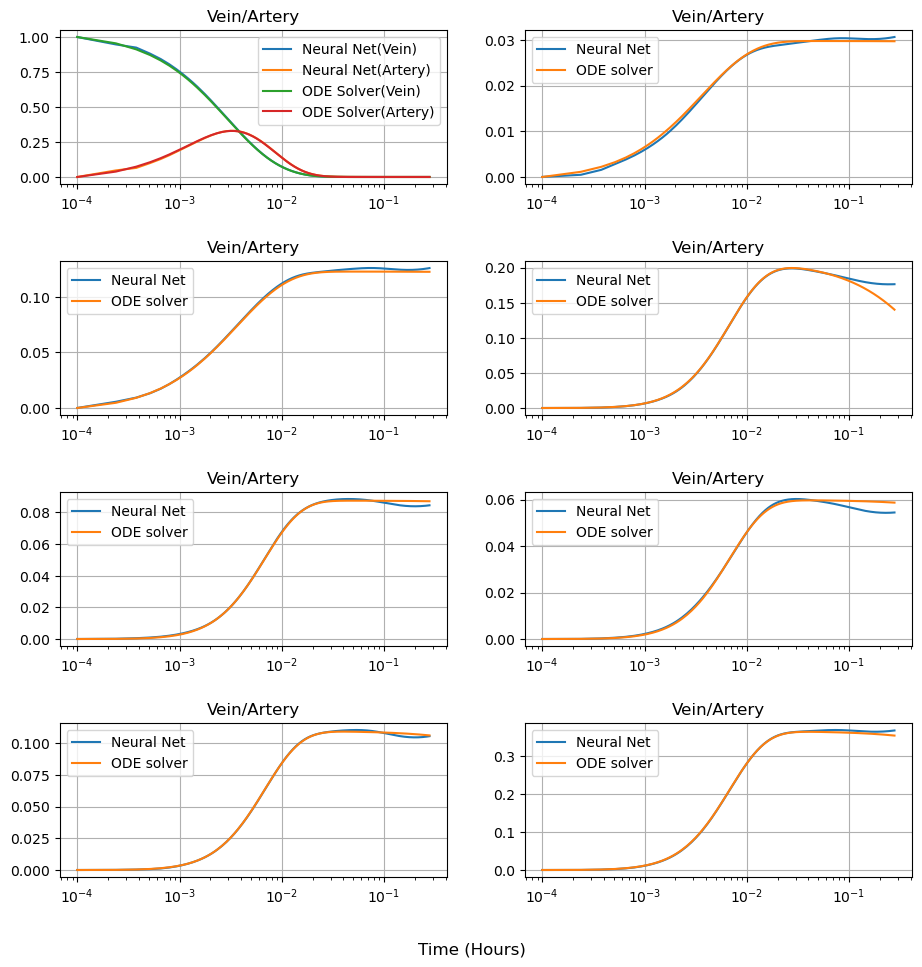

In [16]:
fig = figure(figsize=(11,11))
fig.text(0.5, 0.04, "Time (Hours)", ha="center",fontsize=12)
# fig.text(0.04, 0.5, "NP Concentration", va="center", rotation="vertical",fontsize=12)
subplots_adjust(hspace=0.5) # Set the vertical spacing between axes

subplot(421) # Create the 1st axis of a 3x1 array of axes
ax1 = gca()
ax1.set_xscale("log") # Set the x axis to a logarithmic scale
ax1.plot(0.0001.+t/3600, sol[1:2, :]', 0.0001.+t/3600, y_val_ub[1:2, :]')
ax1.set_title("Vein/Artery")
ax1.legend(["Neural Net(Vein)", "Neural Net(Artery)", "ODE Solver(Vein)", "ODE Solver(Artery)"])
grid()

subplot(422) # Create the 1st axis of a 3x1 array of axes
ax1 = gca()
ax1.set_xscale("log") # Set the x axis to a logarithmic scale
ax1.plot(0.0001.+t/3600, sol[3, :], 0.0001.+t/3600, y_val_ub[3, :])
ax1.set_title("Vein/Artery")
ax1.legend(["Neural Net", "ODE solver"])
grid()


subplot(423) # Create the 1st axis of a 3x1 array of axes
ax1 = gca()
ax1.set_xscale("log") # Set the x axis to a logarithmic scale
ax1.plot(0.0001.+t/3600, sol[4, :], 0.0001.+t/3600, y_val_ub[4, :])
ax1.set_title("Vein/Artery")
ax1.legend(["Neural Net", "ODE solver"])
grid()


subplot(424) # Create the 1st axis of a 3x1 array of axes
ax1 = gca()
ax1.set_xscale("log") # Set the x axis to a logarithmic scale
ax1.plot(0.0001.+t/3600, sol[5, :], 0.0001.+t/3600, y_val_ub[5, :])
ax1.set_title("Vein/Artery")
ax1.legend(["Neural Net", "ODE solver"])
grid()


subplot(425) # Create the 1st axis of a 3x1 array of axes
ax1 = gca()
ax1.set_xscale("log") # Set the x axis to a logarithmic scale
ax1.plot(0.0001.+t/3600, sol[6, :], 0.0001.+t/3600, y_val_ub[6, :])
ax1.set_title("Vein/Artery")
ax1.legend(["Neural Net", "ODE solver"])
grid()


subplot(426) # Create the 1st axis of a 3x1 array of axes
ax1 = gca()
ax1.set_xscale("log") # Set the x axis to a logarithmic scale
ax1.plot(0.0001.+t/3600, sol[7, :], 0.0001.+t/3600, y_val_ub[7, :])
ax1.set_title("Vein/Artery")
ax1.legend(["Neural Net", "ODE solver"])
grid()


subplot(427) # Create the 1st axis of a 3x1 array of axes
ax1 = gca()
ax1.set_xscale("log") # Set the x axis to a logarithmic scale
ax1.plot(0.0001.+t/3600, sol[8, :], 0.0001.+t/3600, y_val_ub[8, :])
ax1.set_title("Vein/Artery")
ax1.legend(["Neural Net", "ODE solver"])
grid()


subplot(428) # Create the 1st axis of a 3x1 array of axes
ax1 = gca()
ax1.set_xscale("log") # Set the x axis to a logarithmic scale
ax1.plot(0.0001.+t/3600, sol[9, :], 0.0001.+t/3600, y_val_ub[9, :])
ax1.set_title("Vein/Artery")
ax1.legend(["Neural Net", "ODE solver"])
grid()
 